In [351]:
%load_ext autoreload
%autoreload 2
import os
import pickle as pkl
import itertools
from functools import partial
from os.path import join as oj
from collections import defaultdict
import warnings

warnings.filterwarnings(action="ignore", category=UserWarning)

import imodels
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imodels.util import data_util
from numpy import concatenate as npcat
from tqdm import tqdm
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn import metrics, model_selection
from sklearn.neighbors import KernelDensity
from sklearn.neural_network import MLPClassifier

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)
mpl.rcParams['figure.dpi'] = 250
np.random.seed(0)

# change working directory to project root
while os.getcwd().split('/')[-1] != 'imodels-experiments':
    os.chdir('..')

import viz
import validate

DATASET = 'csi'
SPLIT_SEED = 6
RESULT_PATH = f'notebooks/transfertree/results/{DATASET}/seed_{SPLIT_SEED}'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [352]:
def all_stats_curve(y_test, preds_proba, plot=False, thresholds=None, model_name=None):
    '''preds_proba should be 1d
    '''
    if thresholds is None:
        thresholds = sorted(np.unique(preds_proba))
    all_stats = {
        s: [] for s in ['sens', 'spec', 'ppv', 'npv', 'lr+', 'lr-', 'f1']
    }
    for threshold in tqdm(thresholds):
        preds = preds_proba > threshold
        tn, fp, fn, tp = metrics.confusion_matrix(y_test, preds).ravel()
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            sens = tp / (tp + fn)
            spec = tn / (tn + fp)
            all_stats['sens'].append(sens)
            all_stats['spec'].append(spec)
            all_stats['ppv'].append(tp / (tp + fp))
            all_stats['npv'].append(tn / (tn + fn))
            all_stats['lr+'].append(sens / (1 - spec))
            all_stats['lr-'].append((1 - sens) / spec)
            all_stats['f1'].append(tp / (tp + 0.5 * (fp + fn)))

    if plot:
        if 'pecarn' in model_name.lower():
            plt.plot(all_stats['sens'][0], all_stats['spec'][0], '.-', label=model_name)
        else:
            plt.plot(all_stats['sens'], all_stats['spec'], '.-', label=model_name)
        plt.xlabel('sensitivity')
        plt.ylabel('specificity')
        plt.grid()
    return all_stats, thresholds

In [353]:
results = defaultdict(lambda:[])
columns = [f'spec9{i}' for i in range(0, 9, 2)] + ['aps', 'auc', 'acc', 'args']

def log_results(model, model_name, X_test, y_test, model_args=None):
    pred_proba_args = (X_test,)
    
    spec_scorer_list = [validate.make_best_spec_high_sens_scorer(sens) for sens in [0.9, 0.92, 0.94, 0.96, 0.98]]
    spec_scores = [scorer(y_test, model.predict_proba(*pred_proba_args)[:, 1]) for scorer in spec_scorer_list]
    apc = metrics.average_precision_score(y_test, model.predict_proba(*pred_proba_args)[:, 1])
    auc = metrics.roc_auc_score(y_test, model.predict_proba(*pred_proba_args)[:, 1])
    acc = metrics.accuracy_score(y_test, model.predict(X_test))
    results[model_name] = spec_scores + [apc, auc, acc, model_args]

In [354]:
class TransferTree:
    def __init__(self, model_0, model_1, model_1_log_arr):
        self.model_0 = model_0
        self.model_1 = model_1
        self.model_1_log_arr = model_1_log_arr

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

    def predict_proba(self, X):
        preds_proba = np.zeros((X.shape[0], 2))
        preds_proba[~self.model_1_log_arr] = self.model_0.predict_proba(
            X[~self.model_1_log_arr])
        preds_proba[self.model_1_log_arr] = self.model_1.predict_proba(
            X[self.model_1_log_arr])
        return preds_proba

class PECARNModel:
    def __init__(self, young):
        self.young = young

    def predict(self, X: pd.DataFrame):
        if DATASET != 'csi' and self.young:
            factors_sum = (
                X['AMS'] + X['HemaLoc_Occipital'] + X['HemaLoc_Parietal/Temporal'] + X['LocLen_1-5 min'] + 
                X['LocLen_5 sec - 1 min'] + X['LocLen_>5 min'] + X['High_impact_InjSev_High'] + 
                X['SFxPalp_Unclear'] + X['SFxPalp_Yes'] + (1 - X['ActNorm']))
        elif DATASET != 'csi':
            factors_sum = (
                X['AMS'] + X['Vomit'] + X['LOCSeparate_Suspected'] + X['LOCSeparate_Yes'] + 
                X['High_impact_InjSev_High'] + X['SFxBas'] +  X['HASeverity_Severe'])
        else:
            factors_sum = (
                X['AlteredMentalStatus2'] + X['PainNeck2'] + X['FocalNeuroFindings2'] + 
                X['Torticollis2'] + X['subinj_TorsoTrunk2'] + X['Predisposed'] + 
                X['HighriskDiving'] + X['HighriskMVC']
            )
        preds = (factors_sum >= 1).astype(int)

        return preds.values
    
    def predict_proba(self, X: pd.DataFrame):
        preds = np.expand_dims(self.predict(X), axis=1)
        return np.hstack((1 - preds, preds))

In [355]:
X, y, feature_names = data_util.get_clean_dataset(f'{DATASET}_pecarn_pred.csv', data_source='imodels')
X_df = pd.DataFrame(X, columns=feature_names)

In [356]:
def predict_and_save(model, X_test, y_test, model_name=None):
    '''Plots cv and returns cv, saves all stats
    '''
    results = {}
    for x, y, suffix in zip([X_test],
                            [y_test],
                            ['_tune']):
        stats, threshes = all_stats_curve(y, model.predict_proba(x)[:, 1], plot=suffix == '_tune', model_name=model_name)
        for stat in stats.keys():
            results[stat + suffix] = stats[stat]
        results['threshes' + suffix] = threshes
        results['acc'] = metrics.accuracy_score(y, model.predict(x))
    pkl.dump(results, open(oj(RESULT_PATH, model_name + '.pkl'), 'wb'))
    return stats, threshes

## age split

### training propensity model

In [357]:
X_prop_raw, _, fnames_prop = data_util.get_clean_dataset(f'{DATASET}_pecarn_prop.csv', data_source='imodels', convertna=False)

In [358]:
# X_df_prop_raw = pd.DataFrame(X_prop_raw, columns=fnames_prop)
# X_df_prop_raw['outcome'] = y
# y_prop = X_df_prop_raw['AgeTwoPlus'].values
# X_df_prop = X_df_prop_raw.drop(columns=['AgeTwoPlus', 'AgeInMonth', 'AgeinYears', 'outcome'])
# X_prop = X_df_prop.values
# X_prop_train_full, X_prop_test, y_prop_train_full, y_prop_test = model_selection.train_test_split(X_prop, y_prop, test_size=0.2, random_state=SPLIT_SEED)

In [359]:
X_df_prop_raw = pd.DataFrame(X_prop_raw, columns=fnames_prop)
X_df_prop_raw['outcome'] = y
y_prop = (X_df_prop_raw['AgeInYears'] >= 2).astype(int)
X_df_prop = X_df_prop_raw.drop(columns=['AgeInYears', 'outcome'])
X_prop = X_df_prop.values
X_prop_train_full, X_prop_test, y_prop_train_full, y_prop_test = model_selection.train_test_split(X_prop, y_prop, test_size=0.2, random_state=SPLIT_SEED)

In [360]:
prop_model = LogisticRegressionCV(Cs=10, penalty='l1', solver='liblinear', scoring='average_precision')
prop_model.fit(X_prop_train_full, y_prop_train_full)

LogisticRegressionCV(penalty='l1', scoring='average_precision',
                     solver='liblinear')

In [361]:
prop_model.C_

array([2.7825594])

In [362]:
print('APS for 5 CV folds: ', prop_model.scores_[1.0][:, 5])

APS for 5 CV folds:  [0.99043082 0.99333311 0.99169097 0.99375    0.99262609]


In [363]:
prop_scores_train_full = prop_model.predict_proba(X_prop_train_full)[:, 1]

### data setup

In [364]:
is_group_1 = (X_df['AgeInYears'] >= 2).astype(bool)
X_df_clean = X_df.drop(columns=['AgeInYears'])

X_train_full, X_test, y_train_full, y_test, is_group_1_train_full, is_group_1_test = (
    model_selection.train_test_split(X_df_clean, y, is_group_1, test_size=0.2, random_state=SPLIT_SEED))
X_train, X_val, y_train, y_val, is_group_1_train, is_group_1_val, prop_scores_train, prop_scores_val = (
    model_selection.train_test_split(X_train_full, y_train_full, is_group_1_train_full, prop_scores_train_full, test_size=0.25, random_state=SPLIT_SEED))

X_train_young, X_val_young, X_test_young = X_train[~is_group_1_train], X_val[~is_group_1_val], X_test[~is_group_1_test]
X_train_old, X_val_old, X_test_old = X_train[is_group_1_train], X_val[is_group_1_val], X_test[is_group_1_test]
y_train_young, y_val_young, y_test_young = y_train[~is_group_1_train], y_val[~is_group_1_val], y_test[~is_group_1_test]
y_train_old, y_val_old, y_test_old = y_train[is_group_1_train], y_val[is_group_1_val], y_test[is_group_1_test]

X_train_full_old, X_train_full_young = pd.concat((X_train_old, X_val_old)), pd.concat((X_train_young, X_val_young))
y_train_full_old, y_train_full_young = npcat((y_train_old, y_val_old)), npcat((y_train_young, y_val_young))

In [365]:
cls_ratio = lambda x: int(pd.Series(x).value_counts()[0.0] / pd.Series(x).value_counts()[1.0])

cls_ratio_train_young = cls_ratio(y_train_young)
cls_ratio_train_old = cls_ratio(y_train_old)
cls_ratio_train = cls_ratio(y_train)

sw_train_young = y_train_young * cls_ratio_train_young + 1
sw_train_old = y_train_old * cls_ratio_train_old + 1
sw_train = y_train * cls_ratio_train + 1

sw_train_full_young = y_train_full_young * cls_ratio_train_young + 1
sw_train_full_old = y_train_full_old * cls_ratio_train_old + 1
sw_train_full = y_train_full * cls_ratio_train + 1

In [366]:
max_leaf_nodes_options = [8, 12, 16]
tao_iter_options = [1, 5]

In [367]:
def fit_models(model_cls, model_name, prop=False, tt=False, allages=False):
    if tt:
        tao_iter_options_local = [0]
    elif model_cls == imodels.TaoTreeClassifier:
        tao_iter_options_local = tao_iter_options
    else:
        tao_iter_options_local = [None]

    for msize, tao_iter in itertools.product(max_leaf_nodes_options, tao_iter_options_local):
        if model_cls == DecisionTreeClassifier:
            model_args = {'max_leaf_nodes': msize}
        elif model_cls == imodels.FIGSClassifier:
            model_args = {'max_rules': msize}
        elif model_cls == imodels.TaoTreeClassifier:
            model_args = {'n_iters': tao_iter, 'model_args': {'max_leaf_nodes': msize}, 'update_scoring': 'average_precision'}

        young = model_cls(**model_args)
        old = model_cls(**model_args)
        whole = model_cls(**model_args)

        if not prop:
            young.fit(X_train_young, y_train_young, sample_weight=sw_train_young)
            old.fit(X_train_old, y_train_old, sample_weight=sw_train_old)
        else:
            young.fit(X_train, y_train, sample_weight=(1 - prop_scores_train) * sw_train)
            old.fit(X_train, y_train, sample_weight= prop_scores_train * sw_train)
        
        if tt:
            for _ in range(2):
                num_updates = young._tao_iter_cart(
                    X_train_old.values, y_train_old, young.model.tree_, 
                    X_train_young.values, y_train_young, sample_weight=y_train_old * sw_train_old)
                if num_updates == 0:
                        break
        
            for _ in range(2):
                num_updates = old._tao_iter_cart(
                    X_train_young.values, y_train_young, old.model.tree_, 
                    X_train_old.values, y_train_old, sample_weight=sw_train_young)
                if num_updates == 0:
                        break
                
        name_young = f'{model_name}_<2_{msize}'
        name_old = f'{model_name}_>2_{msize}'
        name_whole = f'{model_name}_allage_{msize}'

        if tao_iter not in [None, 0] and not tt:
            name_young += f'_{tao_iter}'
            name_old += f'_{tao_iter}'
            name_whole += f'_{tao_iter}'

        log_results(young, name_young, X_val_young, y_val_young, model_args)
        log_results(old, name_old, X_val_old, y_val_old, model_args)

        if allages:
            whole.fit(X_train, y_train, sw_train)
            log_results(whole, name_whole, X_val, y_val, model_args)

### PECARN

In [368]:
young_pecarn, old_pecarn = PECARNModel(young=False), PECARNModel(young=False)

log_results(young_pecarn, 'PECARN_<2', X_test_young, y_test_young, 0)
log_results(young_pecarn, 'PECARN_>2', X_test_old, y_test_old, 1)
log_results(young_pecarn, 'PECARN_allage', X_test, y_test, 1)

### CART

In [369]:
fit_models(DecisionTreeClassifier, 'CART', allages=True)

In [370]:
fit_models(DecisionTreeClassifier, 'PCART', prop=True)

In [371]:
fit_models(imodels.TaoTreeClassifier, 'TTCART', tt=True)

### FIGS

In [372]:
fit_models(imodels.FIGSClassifier, 'FIGS', allages=True)

In [373]:
fit_models(imodels.FIGSClassifier, 'PFIGS', prop=True)

### TAO

In [374]:
fit_models(imodels.TaoTreeClassifier, 'TAO', allages=True)

In [375]:
# fit_models(imodels.TaoTreeClassifier, 'PTAO', prop=True)

### TODO: GOSDT, C4.5 ?

### Validation results for >2 group

In [376]:
pd.set_option('precision', 3)
all_results = pd.DataFrame.from_dict(results, orient='index', columns=columns)
old_results = all_results[all_results.index.str.contains('>2')]
old_results.iloc[:, :-1].to_csv(oj(RESULT_PATH, 'old_val.csv'))
old_results[['spec90', 'spec94', 'aps']].style.background_gradient()

,spec90,spec94,aps
PECARN_>2,0.288,0.288,0.218
CART_>2_8,0.435,0.388,0.320
CART_>2_12,0.475,0.388,0.363
CART_>2_16,0.481,0.390,0.399
PCART_>2_8,0.435,0.388,0.354
PCART_>2_12,0.475,0.388,0.363
PCART_>2_16,0.442,0.352,0.395
TTCART_>2_8,0.435,0.388,0.320
TTCART_>2_12,0.475,0.388,0.363
TTCART_>2_16,0.481,0.390,0.399


In [379]:
args = all_results['args']

best_cart = DecisionTreeClassifier(**args['CART_>2_16']).fit(X_train_full_old, y_train_full_old, sw_train_full_old)
best_pcart = DecisionTreeClassifier(**args['PCART_>2_12']).fit(X_train_full, y_train_full, prop_scores_train_full * sw_train_full)
best_ttcart = imodels.TaoTreeClassifier(**args['TTCART_>2_16']).fit(X_train_full_old, y_train_full_old, sw_train_full_old)
for _ in range(2):
    best_ttcart._tao_iter_cart(
        X_train_full_young.values, y_train_full_young, best_ttcart.model.tree_, X_train_full_old.values, y_train_full_old, sw_train_full_young)

best_figs = imodels.FIGSClassifier(**args['FIGS_>2_16']).fit(
    X_train_full_old, y_train_full_old, sample_weight=sw_train_full_old)
best_pfigs = imodels.FIGSClassifier(**args['PFIGS_>2_16']).fit(
    X_train_full, y_train_full, sample_weight=prop_scores_train_full * sw_train_full)

best_tao = imodels.TaoTreeClassifier(**args['TAO_>2_16_1']).fit(
    X_train_full_old, y_train_full_old, sample_weight = sw_train_full_old)

100%|██████████| 2/2 [00:00<00:00, 372.66it/s]


(0.5, 1.1)

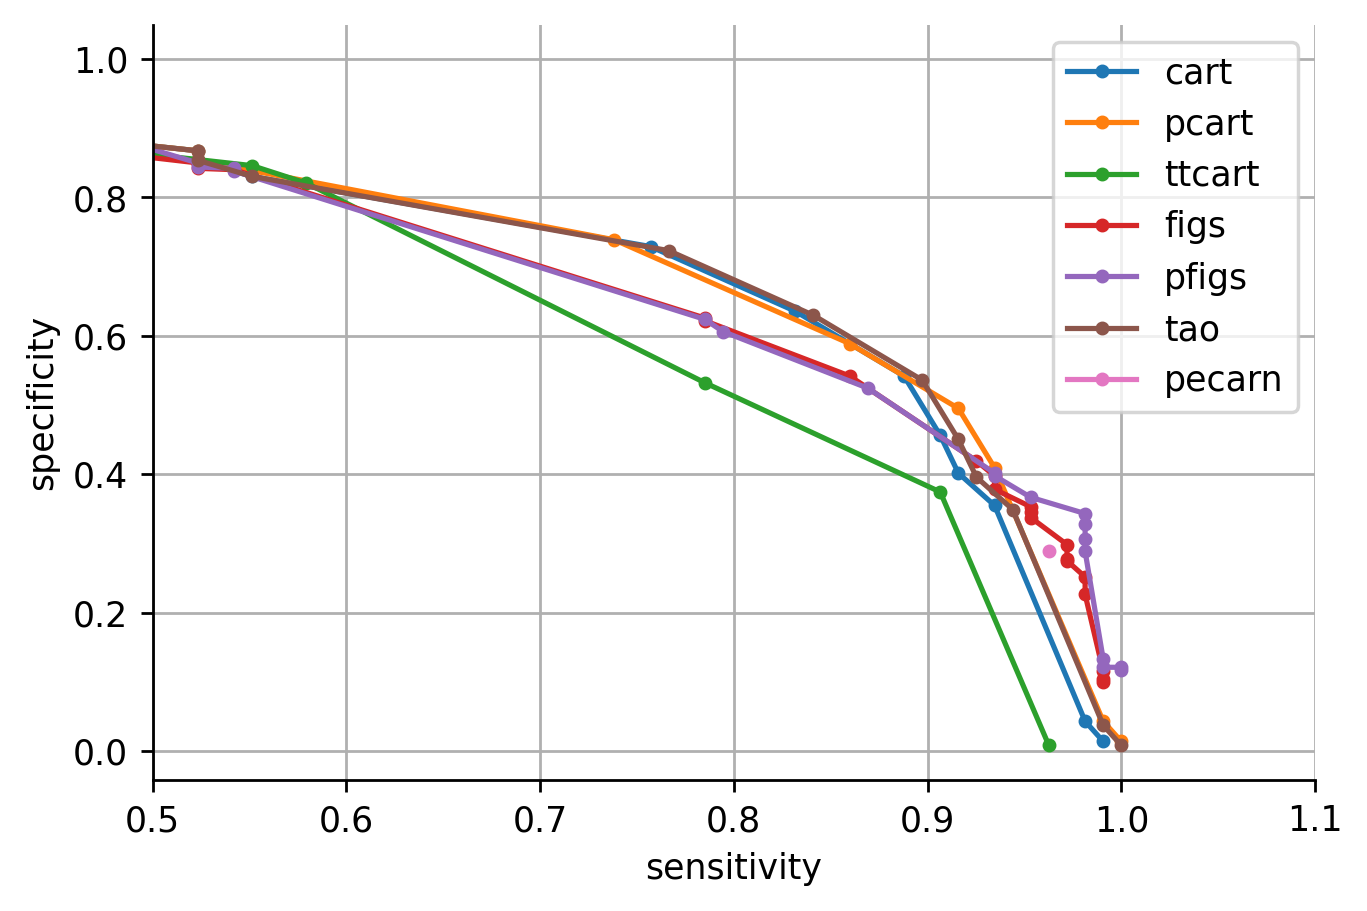

In [380]:
stats, threshes = predict_and_save(best_cart, X_test_old, y_test_old, 'cart')
stats, threshes = predict_and_save(best_pcart, X_test_old, y_test_old, 'pcart')
stats, threshes = predict_and_save(best_ttcart, X_test_old, y_test_old, 'ttcart')
stats, threshes = predict_and_save(best_figs, X_test_old.values, y_test_old, 'figs')
stats, threshes = predict_and_save(best_pfigs, X_test_old.values, y_test_old, 'pfigs')
stats, threshes = predict_and_save(best_tao, X_test_old.values, y_test_old, 'tao')
# stats, threshes = predict_and_save(best_ptao, X_test_old.values, y_test_old, 'ptao')
stats, threshes = predict_and_save(old_pecarn, X_test_old, y_test_old, 'pecarn')
plt.legend()
plt.xlim(0.5, 1.1)

### results for <2 group

In [381]:
young_results = all_results[all_results.index.str.contains('<2')]
young_results.iloc[:, :-1].to_csv(oj(RESULT_PATH, 'young_val.csv'))
young_results[['spec90', 'spec94', 'aps']].style.background_gradient()

,spec90,spec94,aps
PECARN_<2,0.514,0.514,0.320
CART_<2_8,0.000,0.000,0.155
CART_<2_12,0.000,0.000,0.155
CART_<2_16,0.000,0.000,0.164
PCART_<2_8,0.657,0.657,0.569
PCART_<2_12,0.629,0.629,0.616
PCART_<2_16,0.029,0.029,0.628
TTCART_<2_8,0.000,0.000,0.155
TTCART_<2_12,0.000,0.000,0.155
TTCART_<2_16,0.000,0.000,0.164


In [382]:
args = all_results['args']

best_cart_young = DecisionTreeClassifier(**args['CART_>2_16']).fit(X_train_full_young, y_train_full_young, sw_train_full_young)
best_pcart_young = DecisionTreeClassifier(**args['PCART_>2_8']).fit(X_train_full, y_train_full, (1 - prop_scores_train_full) * sw_train_full)
best_ttcart_young = imodels.TaoTreeClassifier(**args['TTCART_>2_16']).fit(X_train_full_young, y_train_full_young, sw_train_full_young)
for _ in range(2):
    best_ttcart_young._tao_iter_cart(
        X_train_full_old.values, y_train_full_old, best_ttcart_young.model.tree_, X_train_full_young.values, y_train_full_young, sw_train_full_old)

best_figs_young = imodels.FIGSClassifier(**args['FIGS_>2_16']).fit(
    X_train_full_young, y_train_full_young, sample_weight=sw_train_full_young)
best_pfigs_young = imodels.FIGSClassifier(**args['PFIGS_>2_8']).fit(
    X_train_full, y_train_full, sample_weight=(1 - prop_scores_train_full) * sw_train_full)

best_tao_young = imodels.TaoTreeClassifier(**args['TAO_>2_16_1']).fit(
    X_train_full_young, y_train_full_young, sample_weight = sw_train_full_young)
# best_ptao_young = imodels.TaoTreeClassifier(**args['PTAO_>2_12_1']).fit(
#     X_train_full, y_train_full, sample_weight = (1 - prop_scores_train_full) * sw_train_full)

100%|██████████| 2/2 [00:00<00:00, 1271.58it/s]


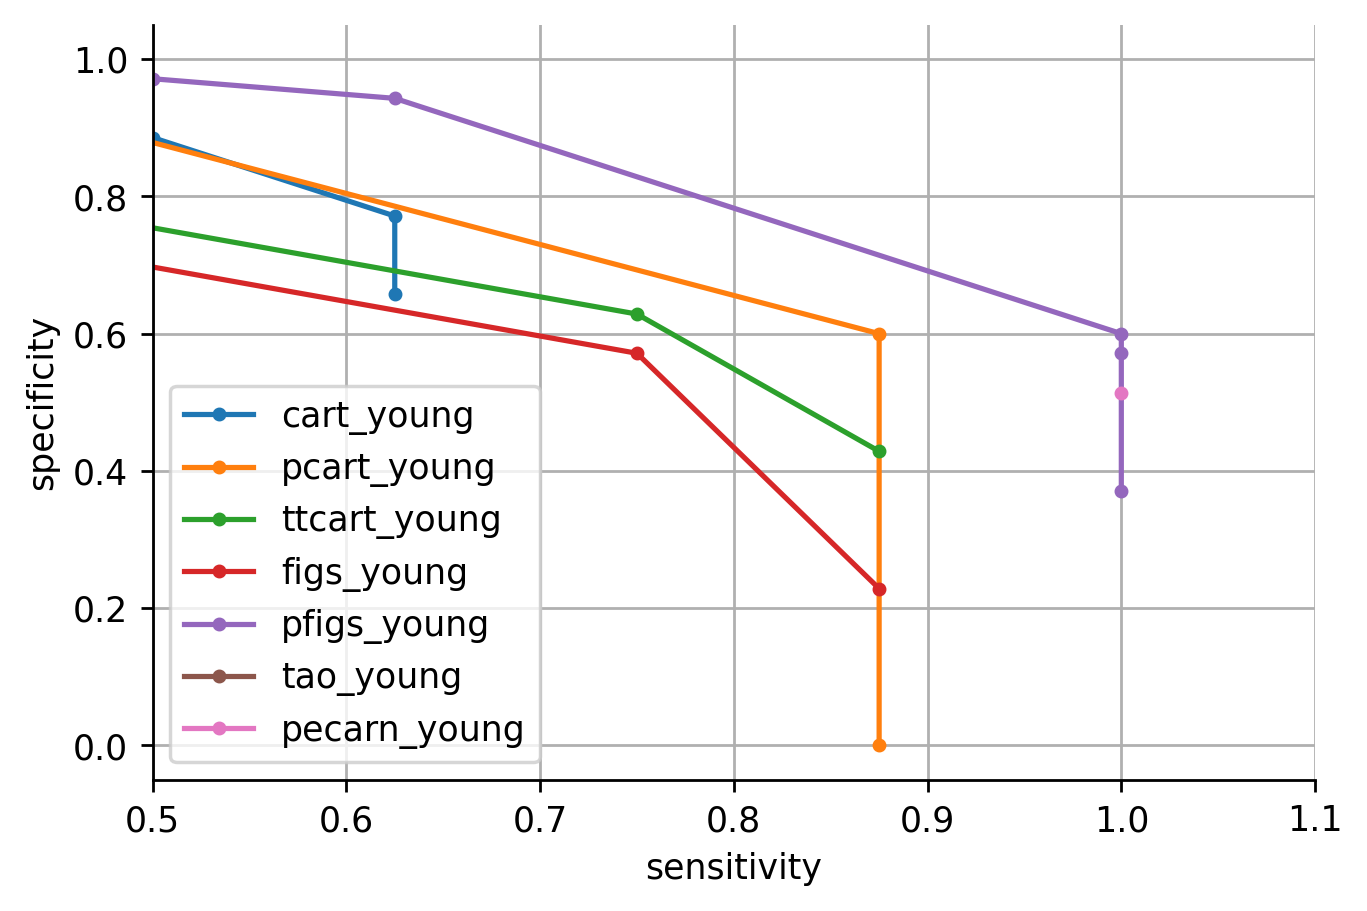

In [383]:
stats, threshes = predict_and_save(best_cart_young,  X_test_young, y_test_young, 'cart_young')
stats, threshes = predict_and_save(best_pcart_young, X_test_young, y_test_young, 'pcart_young')
stats, threshes = predict_and_save(best_ttcart_young, X_test_young.values, y_test_young, 'ttcart_young')
stats, threshes = predict_and_save(best_figs_young, X_test_young.values, y_test_young, 'figs_young')
stats, threshes = predict_and_save(best_pfigs_young, X_test_young.values, y_test_young, 'pfigs_young')
stats, threshes = predict_and_save(best_tao_young, X_test_old.values, y_test_old, 'tao_young')
# stats, threshes = predict_and_save(best_ptao_young, X_test_young.values, y_test_young, 'ptao_young')
stats, threshes = predict_and_save(young_pecarn, X_test_young, y_test_young, 'pecarn_young')
plt.xlim(0.5, 1.1)
plt.legend()

### all ages results

In [384]:
allage_results = all_results[all_results.index.str.contains('allage')]
allage_results.iloc[:, :-1].to_csv(oj(RESULT_PATH, 'allage_val.csv'))
allage_results[['spec90', 'spec94', 'aps']].style.background_gradient()

,spec90,spec94,aps
PECARN_allage,0.303,0.303,0.223
CART_allage_8,0.449,0.405,0.322
CART_allage_12,0.445,0.402,0.351
CART_allage_16,0.488,0.371,0.383
FIGS_allage_8,0.371,0.371,0.383
FIGS_allage_12,0.402,0.402,0.390
FIGS_allage_16,0.443,0.375,0.394
TAO_allage_8_1,0.000,0.000,0.374
TAO_allage_8_5,0.000,0.000,0.374
TAO_allage_12_1,0.371,0.371,0.365


In [385]:
best_cart_allage = DecisionTreeClassifier(**args['CART_allage_8']).fit(X_train_full, y_train_full, sw_train_full)
best_figs_allage = imodels.FIGSClassifier(**args['FIGS_allage_12']).fit(X_train_full, y_train_full, sample_weight=sw_train_full)
best_tao_allage = imodels.TaoTreeClassifier(**args['TAO_allage_16_1']).fit(X_train_full, y_train_full, sample_weight = sw_train_full)
best_pcart_allage = TransferTree(best_pcart_young, best_pcart, is_group_1_test)
best_ttcart_allage = TransferTree(best_ttcart_young, best_ttcart, is_group_1_test)
best_pfigs_allage = TransferTree(best_pfigs_young, best_pfigs, is_group_1_test)
# best_figmix_allage = TransferTree(best_pfigs_young, best_figs_allage, is_group_1_test)

100%|██████████| 2/2 [00:00<00:00, 388.11it/s]


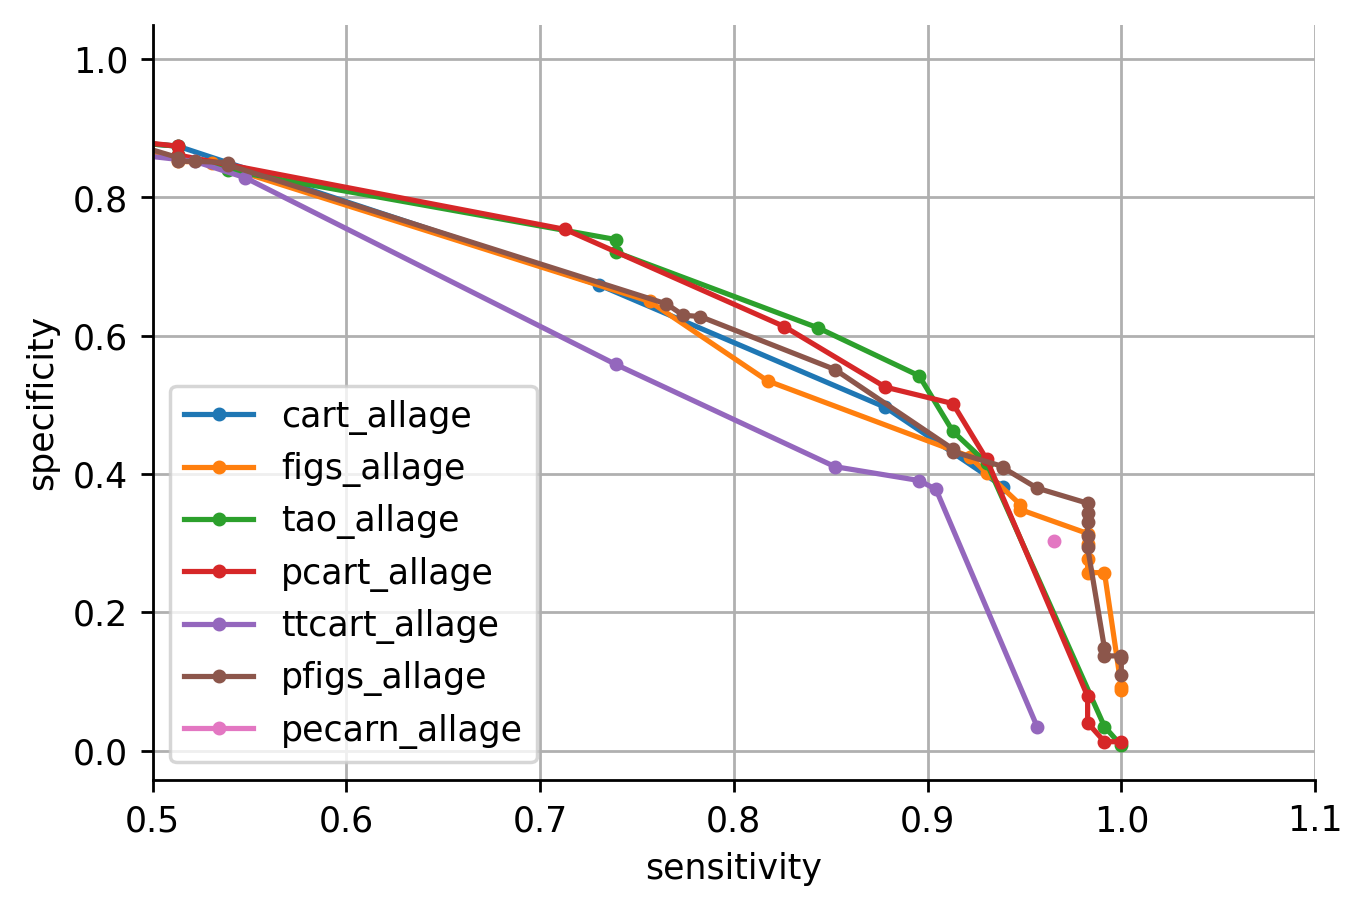

In [386]:
stats, threshes = predict_and_save(best_cart_allage,  X_test, y_test, 'cart_allage')
stats, threshes = predict_and_save(best_figs_allage, X_test.values, y_test, 'figs_allage')
stats, threshes = predict_and_save(best_tao_allage, X_test.values, y_test, 'tao_allage')
stats, threshes = predict_and_save(best_pcart_allage, X_test, y_test, 'pcart_allage')
stats, threshes = predict_and_save(best_ttcart_allage, X_test, y_test, 'ttcart_allage')
stats, threshes = predict_and_save(best_pfigs_allage, X_test, y_test, 'pfigs_allage')
# stats, threshes = predict_and_save(best_figmix_allage, X_test, y_test, 'figmix_allage')
stats, threshes = predict_and_save(young_pecarn, X_test, y_test, 'pecarn_allage')
plt.xlim(0.5, 1.1)
plt.legend()

[Text(760.0961538461538, 679.5, 'FocalNeuroFindings2 <= 0.5\ngini = 0.497\nsamples = 2475\nvalue = [2069, 2436]'),
 Text(670.6730769230769, 528.5, 'PainNeck2 <= 0.5\ngini = 0.494\nsamples = 2102\nvalue = [1854, 1488]'),
 Text(357.6923076923077, 377.5, 'AlteredMentalStatus2 <= 0.5\ngini = 0.443\nsamples = 1295\nvalue = [1196, 594]'),
 Text(178.84615384615384, 226.5, 'Torticollis2 <= 0.5\ngini = 0.292\nsamples = 862\nvalue = [832, 180]'),
 Text(89.42307692307692, 75.5, 'gini = 0.253\nsamples = 847\nvalue = [823, 144]'),
 Text(268.2692307692308, 75.5, 'gini = 0.32\nsamples = 15\nvalue = [9, 36]'),
 Text(536.5384615384615, 226.5, 'subinj_TorsoTrunk2 <= 0.5\ngini = 0.498\nsamples = 433\nvalue = [364, 414]'),
 Text(447.1153846153846, 75.5, 'gini = 0.497\nsamples = 371\nvalue = [325, 276]'),
 Text(625.9615384615385, 75.5, 'gini = 0.344\nsamples = 62\nvalue = [39, 138]'),
 Text(983.6538461538461, 377.5, 'HighriskDiving <= 0.5\ngini = 0.488\nsamples = 807\nvalue = [658, 894]'),
 Text(894.230769

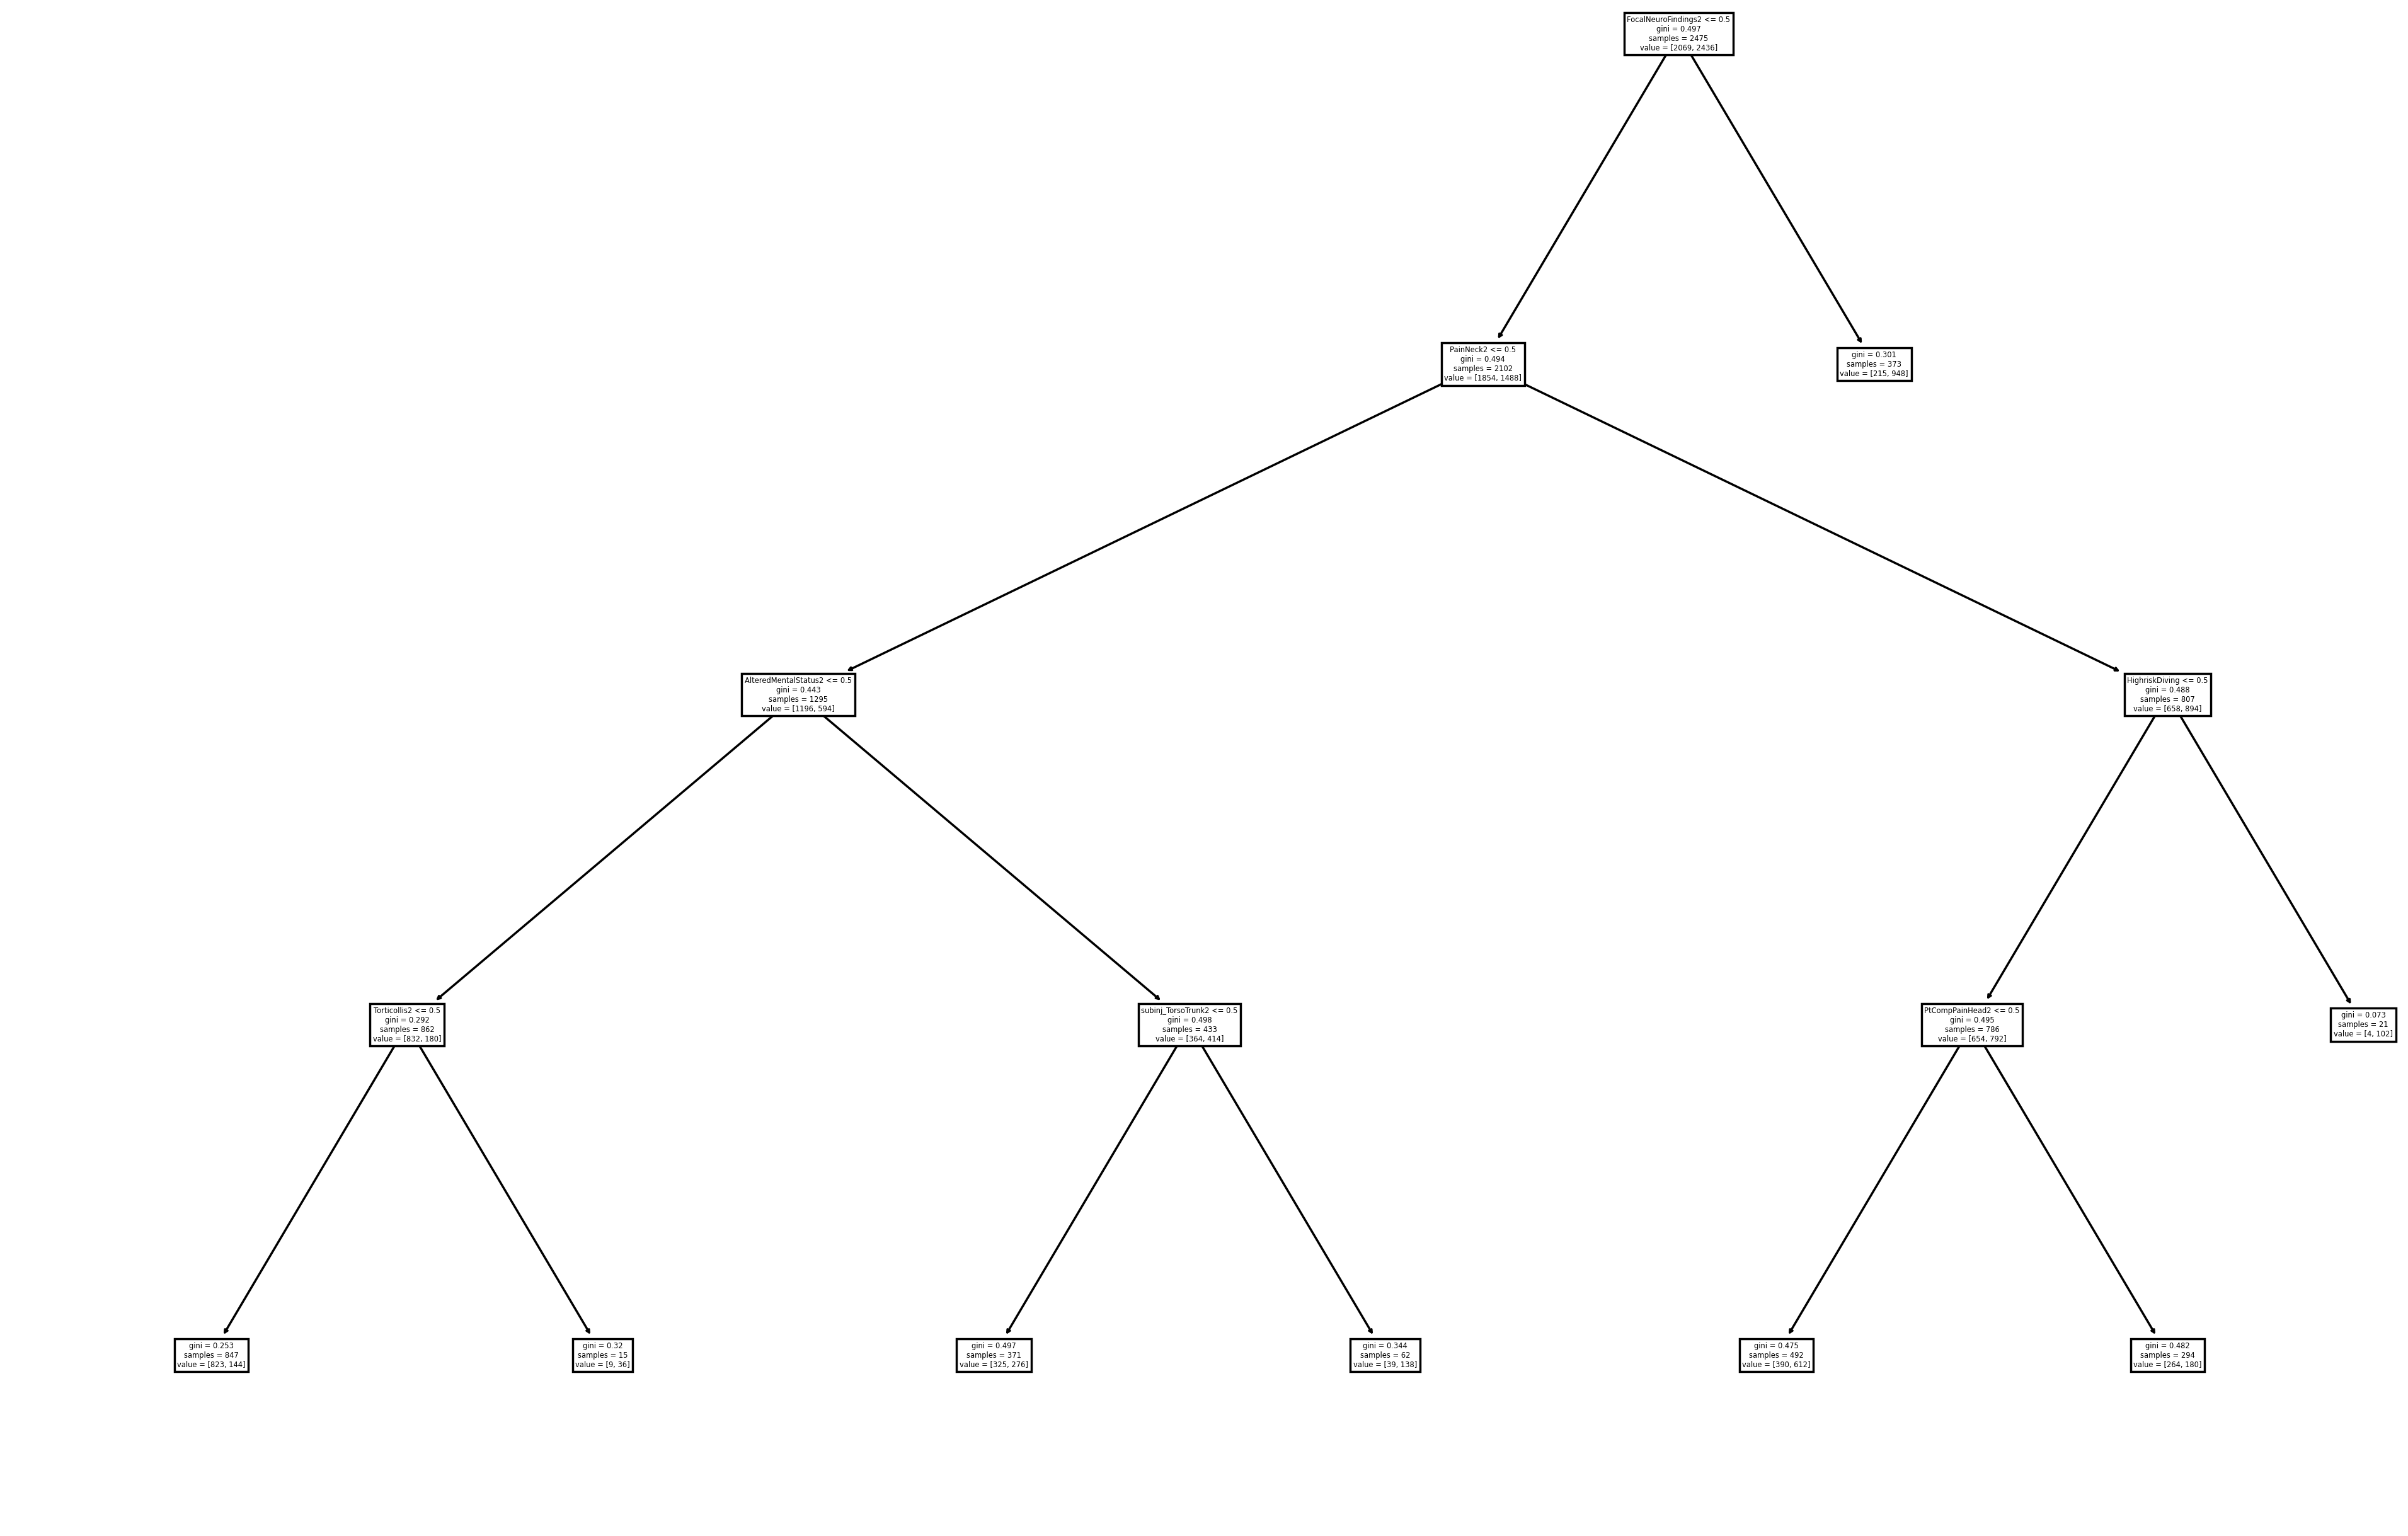

In [433]:
plot_tree(best_cart, feature_names=feature_names)

In [34]:
# plot_tree(best_ttao.model, feature_names=feature_names)

In [432]:
best_figs.feature_names_ = feature_names
print(best_figs)

------------
FocalNeuroFindings2 <= 0.500 (Tree #0 root)
	PainNeck2 <= 0.500 (split)
		AlteredMentalStatus2 <= 0.500 (split)
			Torticollis2 <= 0.500 (split)
				Val: 0.149 (leaf)
				Val: 0.800 (leaf)
			Val: 0.532 (leaf)
		Val: 0.576 (leaf)
	Val: 0.815 (leaf)



In [365]:
best_pfigs_young.feature_names_ = feature_names
print(best_pfigs_young)

------------
FocalNeuroFindings2 <= 0.500 (Tree #0 root)
	AlteredMentalStatus2 <= 0.500 (split)
		Torticollis2 <= 0.500 (split)
			Predisposed <= 0.500 (split)
				Val: 0.106 (leaf)
				Val: 0.654 (leaf)
			Val: 0.804 (leaf)
		Val: 0.493 (leaf)
	Val: 0.856 (leaf)

	+
subinj_TorsoTrunk2 <= 0.500 (Tree #1 root)
	Val: -0.029 (leaf)
	Val: 0.294 (leaf)

	+
subinj_Ext2 <= 0.500 (Tree #2 root)
	Val: -0.015 (leaf)
	PtCompPainExt2 <= 0.500 (split)
		Val: 0.327 (leaf)
		Val: -0.153 (leaf)

	+
is_ems <= 0.500 (Tree #3 root)
	Val: 0.087 (leaf)
	Val: -0.042 (leaf)



### understanding propensity model

- main features that determine scores

In [37]:
nonzero_ind = np.nonzero(prop_model.coef_[0])[0]
nonzero_ind_sorted = nonzero_ind[np.argsort(prop_model.coef_[0][nonzero_ind])]
prop_model_coefs = pd.DataFrame(prop_model.coef_[0][nonzero_ind_sorted], index=X_df_prop.columns[nonzero_ind_sorted])

In [38]:
important_prop_features = pd.concat((prop_model_coefs.iloc[:10], prop_model_coefs.iloc[-10:]))
important_prop_features.style.background_gradient()

,0
FontBulg_nan,-2.416
HA_verb_91.0,-1.540
InjuryMech_FallStair,-1.495
VomitStart_Before head injury,-1.294
InjuryMech_FallElev,-1.231
InjuryMech_Other,-1.005
Amnesia_verb_91.0,-0.571
FontBulg_1.0,-0.520
LocLen_Not applicable,-0.488
OSI_0.0,-0.473


- distribution of scores

<AxesSubplot:xlabel='prop_score', ylabel='Density'>

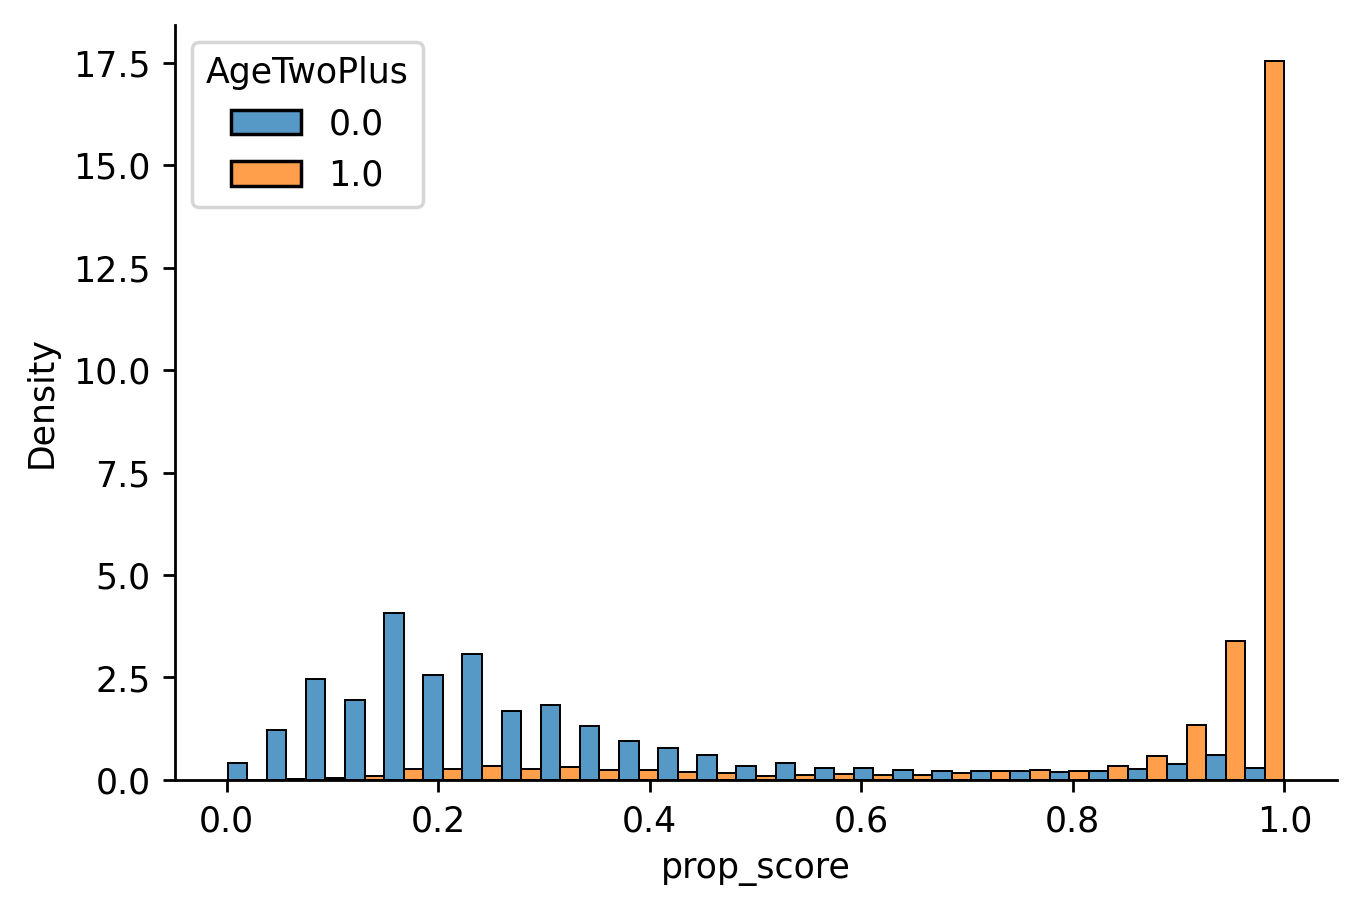

In [39]:
X_df_prop_raw_train_full, X_df_test = model_selection.train_test_split(X_df_prop_raw, test_size=0.2, random_state=SPLIT_SEED)
X_df_prop_raw_train_full['prop_score'] = prop_scores_train_full
sns.histplot(data=X_df_prop_raw_train_full, x='prop_score', hue='AgeTwoPlus', multiple='dodge', stat="density", common_norm=False)

- relationship between scores and age in months

In [40]:
X_df_prop_raw_train_full_younger = X_df_prop_raw_train_full[X_df_prop_raw_train_full['AgeInMonth'] < 50]

<AxesSubplot:xlabel='prop_score', ylabel='AgeInMonth'>

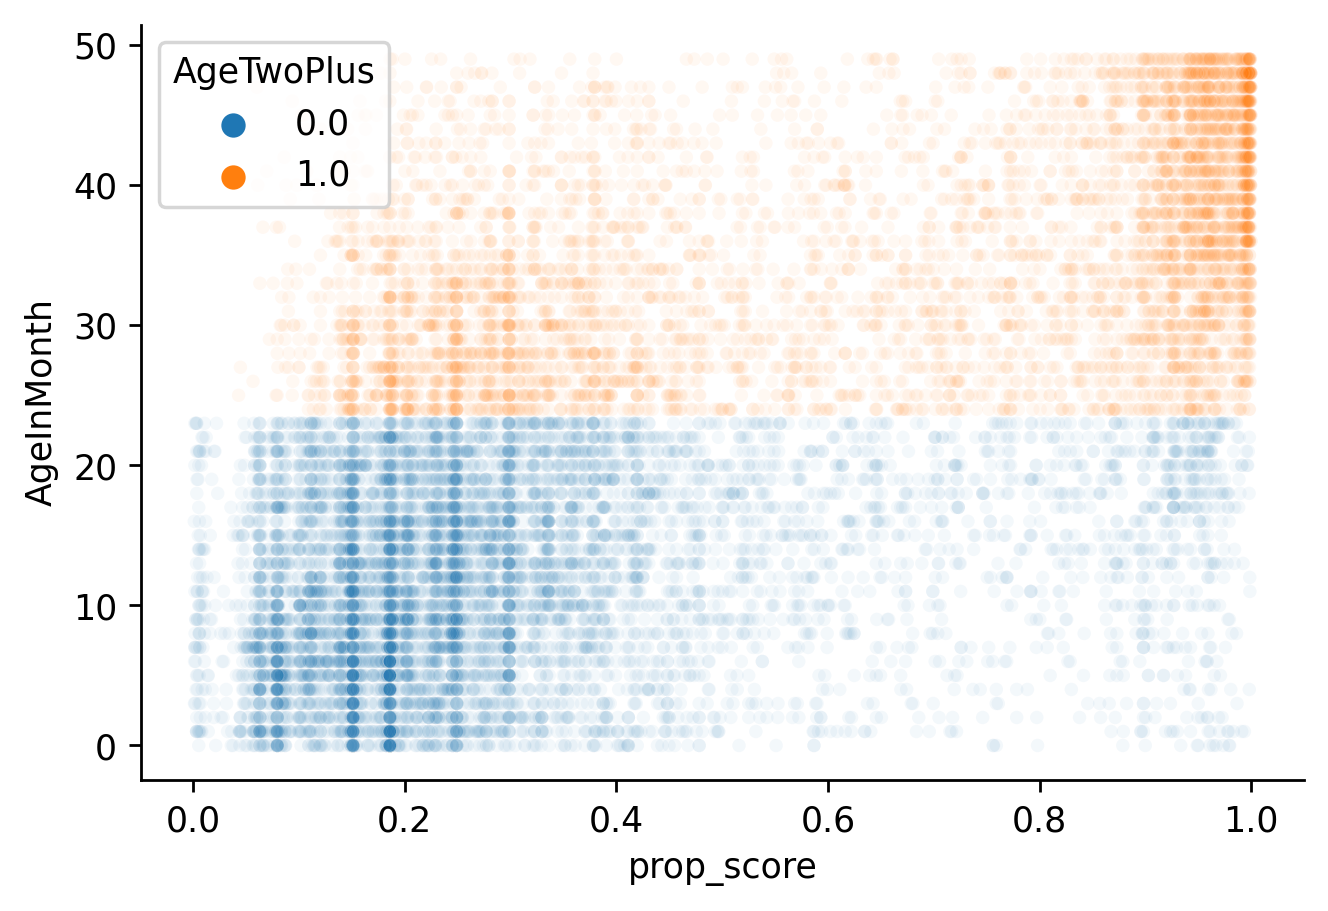

In [41]:
sns.scatterplot(data=X_df_prop_raw_train_full_younger, x='prop_score', y='AgeInMonth', hue = 'AgeTwoPlus', alpha=0.05, s=15)

- possible further analysis: dig into the cluster of patients with age over two with prop scores in (0.1, 0.4) seen above

clusters of pts with exact same prop score

In [42]:
X_df_prop_raw_train_full['prop_score'].value_counts()

0.151    288
0.186    287
0.299    207
0.249    185
0.998    161
        ... 
0.796      1
0.994      1
0.927      1
0.981      1
0.731      1
Name: prop_score, Length: 17972, dtype: int64

In [43]:
same_score_points = X_df_prop_raw_train_full[X_df_prop_raw_train_full['prop_score'].round(6) == 0.154315]
same_score_points.std(axis=0)[same_score_points.std(axis=0) > 0]

Series([], dtype: float64)

In [44]:
# young_misclass = (X_df_prop_raw_train_full['prop_score'] > 0.6) & (X_df_prop_raw_train_full['AgeTwoPlus'] == 0)
# young_class = (X_df_prop_raw_train_full['prop_score'] < 0.6) & (X_df_prop_raw_train_full['AgeTwoPlus'] == 0)
# old_misclass = (X_df_prop_raw_train_full['prop_score'] < 0.4) & (X_df_prop_raw_train_full['AgeTwoPlus'] == 1)
# old_class = (X_df_prop_raw_train_full['prop_score'] > 0.4) & (X_df_prop_raw_train_full['AgeTwoPlus'] == 1)

In [45]:
# yg_diffs = X_df_prop_raw_train_full.loc[young_misclass, important_prop_features.index].describe() - X_df_prop_raw_train_full.loc[young_class, important_prop_features.index].describe()
# yg_diffs.abs().sort_values(by='mean', axis=1, ascending=False)

In [46]:
# old_diffs = X_df_prop_raw_train_full.loc[old_misclass, important_prop_features.index].describe() - X_df_prop_raw_train_full.loc[old_class, important_prop_features.index].describe()
# old_diffs.abs().sort_values(by='mean', axis=1, ascending=False)